# Can we Identify Russian Trolls on Twitter?
### By: Collin Pampalone

## Overview
In recent years the media and politicians have been increasingly concerned about foreign influence of US media, especially by Russian Trolls. Social Media platforms such as Twitter provide enormous platforms for trolls to push different agendas. Domestic users of these platforms may be unknowingly bombarded by foreign rhetoric that ultimately affects their views on US politics. 

Many users of social media platforms, politicians, and news pundits have argued that the platforms have a responsibility to remove political trolls. But in an age where tweets are posted as rapidly as opinions are formed, how can platforms identify trolls? In my project I have created a learning model that identifies troll tweets from text alone. Using a similar model, social media platforms could remove or flag suspicious tweets as they are posted, helping mitigate the liability and reputation risk posed by trolls.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from time import time
from textblob import TextBlob, Word

import logging
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn import metrics

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\599701\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data
I pulled my data from several external sources, so I needed to import it and format it inorder to get a single unified dataset. While there was a lot of meta data available, I was mostly concerned with the author, their category (troll/news outlet), and political leaning, and tweet content. Troll tweets were downloaded from FiveThirtyEight, non-trolls were from scraped from twitter with Twarc and data from GWU from a list of mainstream media outlets.

To process the data, I downsampled the original datasets from several million to about 1,000,000. I then discarded tweets where the author or content was missing. I also got rid of non-english tweets, tweets that were simply a link or image with no other context, and tweets that contained only emojis.

Finally, I resampled the data so that I had an equal number of-trolls and non trolls. This helps prevent class imbalances.

In [2]:
tweet_data = pd.read_csv("./datasets/combined_data.csv", sep=";", 
                         dtype={'tweet_id':str, 'author_id':str, 'publish_date':str, 
                                'content':str, 'link_url':str, 'account_category':str, 
                                'author':str, 'account_type':str})
tweet_data = tweet_data.loc[(tweet_data.account_category == 'Troll') | (tweet_data.account_category == 'US_News')]

A look at Null values across my data. Link_url is totally empty, but this won't be important for my analysis. I just need content, author, and account category (troll or news). 

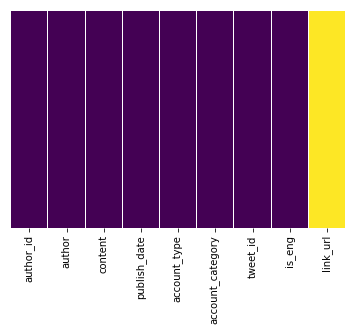

In [3]:
sns.heatmap(tweet_data.isnull(), yticklabels = False, cbar = False, cmap = "viridis");

## Inital EDA

We want to check how the data is spead out.

A look at how tweets are spread out over category and political leaning.

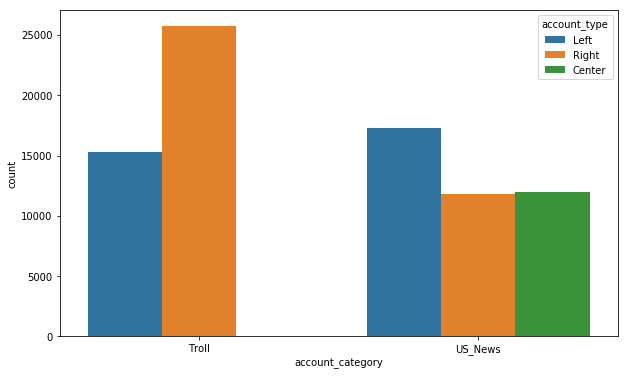

In [4]:
plt.subplots(figsize=(10,6));
sns.countplot(x=tweet_data['account_category'], hue=tweet_data['account_type']);

Let's take a look at the sentiment as well

In [5]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

tweet_data['sentiment'] = tweet_data.content.apply(detect_sentiment)

## Sentiment
Sentiment analysis (polarity) is one of the packages provided by TextBlob. It measures the use of negetive and postive words and assigns a corresponding score. By taking a look at sentiment across different categories, there may be a pattern that appears.

### Sentiment by `account_category`

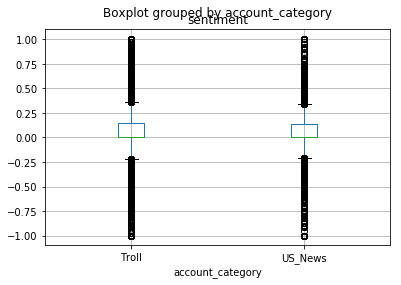

In [6]:
tweet_data.boxplot(column='sentiment', by='account_category');

### Sentiment by political leaning

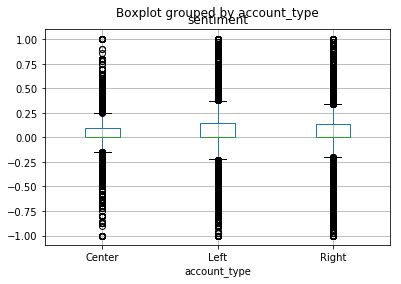

In [7]:
tweet_data.boxplot(column='sentiment', by='account_type');

Since the boxplots didn't show any significant difference, I'll use groupby to take a deeper dive into sentiment. 

The means vary slightly. We can see that center leaning tweets are less positive (more neautral) while Left are more positive. 

We can also see troll tweets have slightly higher standard deviation.

|account_category|account_type|count|mean|std|
|----------------|------------|-----|----|---|
|Troll|Left|15314.0|0.071811|0.283470|
|Troll|Right|25755.0|0.041765|0.299117|
|US_News|Center|11972.0|0.044006|0.221426|
|US_News|Left|17320.0|0.053626|0.242326|
|US_News|Right|11777.0|0.047574|0.240826|

In [8]:
tweet_data.groupby(by=['account_category', 'account_type']).sentiment.describe()

count      mean       std  min  25%  50%  \
account_category account_type                                               
Troll            Left          15314.0  0.071811  0.283470 -1.0  0.0  0.0   
                 Right         25755.0  0.041765  0.299117 -1.0  0.0  0.0   
US_News          Center        11972.0  0.044006  0.221426 -1.0  0.0  0.0   
                 Left          17320.0  0.053626  0.242326 -1.0  0.0  0.0   
                 Right         11777.0  0.047574  0.240826 -1.0  0.0  0.0   

                                    75%  max  
account_category account_type                 
Troll            Left          0.175000  1.0  
                 Right         0.136364  1.0  
US_News          Center        0.100000  1.0  
                 Left          0.136364  1.0  
                 Right         0.136364  1.0

## NLP Preperation
Now to start using NLP. I need to stem the words in the tweet text. This will reduce the number of features and improve the performance of my a model.

In [9]:
tweet_data = pd.get_dummies(tweet_data, columns=['account_category'], drop_first=False)
df_Troll = tweet_data[tweet_data.account_category_Troll == 1]
df_News = tweet_data[tweet_data.account_category_US_News == 1]

df_Trolls_News = pd.concat([df_Troll, df_News])

In [10]:
# Define a function that accepts text and returns a list of stems.
stemmer = SnowballStemmer('english')
def split_into_stems(text):
    text = str(text).lower()
    words = TextBlob(text).words
    return [stemmer.stem(word) for word in words]

In [11]:
stemmed_stops = [stemmer.stem(Word(x)) for x in stopwords.words('english')]

Now I need to do the test-train-split and evaluate my results. The options for the model I chose were determined by a grid search.

In [12]:
X = df_Trolls_News['content']
y = df_Trolls_News['account_category_Troll']
X_train, X_test, y_train, y_test = tts(X, y, random_state=42)

Now I need to do run the model and evaluate my results. The options for the model I chose were determined by a grid search. with a pipeline. The resulting F1-scores are pretty good, about 85%. 

In [13]:
vect = CountVectorizer(analyzer=split_into_stems, max_df=1.0, min_df=1, stop_words=stemmed_stops, ngram_range=(1,1))
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
print(metrics.classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.81      0.90      0.85     10258
          1       0.89      0.78      0.83     10277

avg / total       0.85      0.84      0.84     20535



To get a better look at some of the tweets that were incorretly or correctly classified,  I made a function to pull some of the most extreemly rated tweets out.

In [14]:
def grab_tweet(tweet):
    print("Author:", tweet['author'])
    print("Probability troll:", tweet['proba_troll'])
    print("Tweet text:", tweet['content'])
    print()

In [15]:
df_dtm = vect.transform(df_Trolls_News['content'])
proba = nb.predict_proba(df_dtm)
df_Trolls_News['proba_troll'] = proba[:,1]

In [16]:
print("Most Troll Like")
df_Trolls_News.loc[df_Trolls_News.account_category_Troll==0].sort_values(by='proba_troll', ascending=False).head(3).apply(grab_tweet, axis=1)
print("-----------------------------------------------------------------------------------------------------------------------")
print("Least Troll Like")
df_Trolls_News.loc[df_Trolls_News.account_category_Troll==0].sort_values(by='proba_troll', ascending=True).head(3).apply(grab_tweet, axis=1)

Most Troll Like
Author: nytimes
Probability troll: 0.9999999790185827
Tweet text: RT @jennydeluxe: "Being black in the age of wokeness" is one of my fave episodes to date. Listen &amp; LMK what you think &gt;&gt;&gt;&gt; https://t.co/r4T…

Author: USATODAY
Probability troll: 0.999999959013878
Tweet text: "All I really want to do is tell you that I'm feeling great. I'm glad I spent that evening in the hospital, and it did me a lot of good." -Stan Lee https://t.co/JZg09bqS1g

Author: FoxNews
Probability troll: 0.9999998102654113
Tweet text: .@POTUS on Democrats: "I don't think they want to solve the DACA problem. I think they wanna talk about it. I think they wanna obstruct." https://t.co/zBPxHDzk6E

-----------------------------------------------------------------------------------------------------------------------
Least Troll Like
Author: politico
Probability troll: 3.8849871078629966e-16

 https://t.co/f3A12AevZU https://t.co/wpgmLzoh4p

Author: Reuters
Probability troll: 1.33861565

147799    None
135104    None
136099    None
dtype: object

# News Outlets
# Most Troll Like

### Author: nytimes | Probability troll: 1.00
Tweet text: RT @jennydeluxe: "Being black in the age of wokeness" is one of my fave episodes to date. Listen &amp; LMK what you think &gt;&gt;&gt;&gt; https://t.co/r4T…

### Author: USATODAY | Probability troll: 1.00
Tweet text: "All I really want to do is tell you that I'm feeling great. I'm glad I spent that evening in the hospital, and it did me a lot of good." -Stan Lee https://t.co/JZg09bqS1g

### Author: FoxNews | Probability troll: 1.00
Tweet text: .@POTUS on Democrats: "I don't think they want to solve the DACA problem. I think they wanna talk about it. I think they wanna obstruct." https://t.co/zBPxHDzk6E

# Least Troll Like
### Author: politico | Probability troll: 0.00
Larry Kudlow has been widely seen as a leading candidate to replace Gary Cohn, despite his criticism of Trump’s decision to impose a 10 percent tariff on aluminum and 25 percent tariff on steel imports.
 https://t.co/f3A12AevZU https://t.co/wpgmLzoh4p

### Author: Reuters | Probability troll: 0.00
North Korean leader Kim Jong Un invites South Korean President Moon Jae-in to Pyongyang potentially setting up the first meeting of Korean leaders in more than a decade https://t.co/K7PvzMSyIA @HeeShin @pearswick #PyeongChang2018 https://t.co/kUseNlZ7g2

### Author: HuffPost | Probability troll: 0.00
PyeongChang built itself a brand-new $109 million stadium to host the 2018 Winter Olympic and Paralympic Games. 
And after just four ceremonial events ― including the #OpeningCeremony ― PyeongChang plans to tear the place down. 🤔🤔🤔
Here's more: https://t.co/QnNcDktTVs

In [17]:
print("Most News Like")
df_Trolls_News.loc[df_Trolls_News.account_category_Troll==1].sort_values(by='proba_troll', ascending=True).head().apply(grab_tweet, axis=1)
print("-----------------------------------------------------------------------------------------------------------------------")
print("Least News Like")
df_Trolls_News.loc[df_Trolls_News.account_category_Troll==1].sort_values(by='proba_troll', ascending=False).head().apply(grab_tweet, axis=1)

Most News Like
Author: KANIJJACKSON
Probability troll: 8.54233597680746e-08
Tweet text: Confirmed: Michael Cohen received hundreds of thousands of dollars  from a Russian oligarch Viktor Vekselberg.  The money was paid to a First Republic Bank account Cohen created  for Essential Consultants. This is the same bank  account Cohen used to pay Stormy Daniels $130,000

Author: IMAPHARRELFAKE
Probability troll: 2.3689616812652584e-07
Tweet text: Former Cuban President Fidel Castro dies at age 90, his brother, President Raul Castro announces. https://t.co/gHGSyRFlBi

Author: WORLDNEWSPOLI
Probability troll: 1.5878339961590657e-06
Tweet text: Bao Bao the giant panda leaves Washington zoo for new home in China https://t.co/e6WNrKcrMI https://t.co/QnCVIUb3nQ

Author: COVFEFENATIONUS
Probability troll: 1.9084533260972855e-06
Tweet text: Randall Saito was arrested in Stockton, CA this morning, per  San Joaquin Co Sheriff’s FB page  SJCO credits “a tip from an alert taxi cab driver”  Saito escaped

10951    None
27469    None
19144    None
13334    None
2595     None
dtype: object

# Troll Groups
# Most News Like
### Author: KANIJJACKSON | Probability troll: 0.00
Confirmed: Michael Cohen received hundreds of thousands of dollars  from a Russian oligarch Viktor Vekselberg.  The money was paid to a First Republic Bank account Cohen created  for Essential Consultants. This is the same bank  account Cohen used to pay Stormy Daniels $130,000

### Author: IMAPHARRELFAKE | Probability troll: 0.00
Former Cuban President Fidel Castro dies at age 90, his brother, President Raul Castro announces. https://t.co/gHGSyRFlBi

### Author: WORLDNEWSPOLI | Probability troll: 0.00
Bao Bao the giant panda leaves Washington zoo for new home in China https://t.co/e6WNrKcrMI https://t.co/QnCVIUb3nQ

# Least News Like
### Author: DOROTHIEBELL | Probability troll: 1.0
�#WakeUpAmerica #TeamTrump #CCOT  #2A #MAGA�#millenials #MinorityPolitics #tcot  �Vote!!��Pols think we are stupid� https://t.co/FHTb098aar

### Author: COVFEFENATIONUS | Probability troll: 1.0
'@Acosta @jaketapper @CNN @CNNI @CNNPolitics @CNNSitRoom @WolfBlitzer @JakeTapper @TheLeadCNN @BrianStelter @AnaNavarro @DonLemon @VanJones68 @AndersonCooper @AC360 @JimAcosta  CNN IS #FAKENEWS! CNN IS #FAKENEWS! CNN IS #FAKENEWS! CNN IS #FAKENEWS! CNN IS #FAKENEWS! CNN IS #FAKENEWS!  #FAKENEWS #MAGA'

### Author: PRICEFORPIERCE | Probability troll: 1.0
'@Sandroskeith @Keque_Mage @Always_Woke @MAGA_shopper @AutisteMoM @Dutch_Deplorabl @WanAw000 @jaxon_gator @lordcaccioepepe @HalleyBorderCol @DJTJohnMiller @WDFx2EU95 @mom_vet @ToTheHand @ThomasBernpaine @JonJ_L @HampusSelander @AndrewK_6 @Treeoflife272 @NeonReactionary @LoveUSADawn @nes4america @Silky_Milky_ @dualkoondog @this1isno1 @disawooed @reallyyBecky @polNewsNet @Kekolyte2 @nia4_trump @JJSmithy_ @ang_yow @tcburnett @SpaceTrills @xavispar4 @lemuriangirl @whois_John_Galt @SeanLewandowski @pacman522 @Thomas1774Paine @BoozyVonD @tmntiffers @smwrva @Lord_ofthe_Pies @Psyanidex @EvilHillaryPics @JayVanorman @laughingatitall @nancyyvonne87 @VictorOfKadesh https://t.co/lzCYFcd5qV'

Finally, I want to take a look at how each news outlet scored on average:

|Outlet           |Mean Score|
|------------------|---------|
|Reuters           |0.013266|
|AP                |0.018762|
|chicagotribune    |0.039258|
|ABC               |0.041498|
|politico          |0.050556|
|WSJ               |0.052525|
|NPR               |0.079233|
|CNN               |0.087843|
|USATODAY          |0.114722|
|Forbes            |0.116943|
|nytimes           |0.122085|
|washingtonpost    |0.126263|
|nypost            |0.165859|
|FoxNews           |0.168716|
|HuffPost          |0.220815|

In [18]:
df_Trolls_News.loc[df_Trolls_News.account_category_Troll==0].groupby(by='author').mean().proba_troll.sort_values()

author
Reuters           0.013266
AP                0.018762
chicagotribune    0.039258
ABC               0.041498
politico          0.050556
WSJ               0.052525
NPR               0.079233
CNN               0.087843
USATODAY          0.114722
Forbes            0.116943
nytimes           0.122085
washingtonpost    0.126263
nypost            0.165859
FoxNews           0.168716
HuffPost          0.220815
Name: proba_troll, dtype: float64

## Conclusions

Overall, I the model works pretty well. Given a 50/50 split, the model is able to predict trolls correctly 84% of the time.

|Type     |precision|recall|f1-score|support|
| ------- |:-------:|:----:|:------:|------:|
|News     |0.81     |0.90  |0.85    |10258  |
|Troll    |0.89     |0.78  |0.83    |10277  |

### Limitations

* There was no deep dive into links, images (memes), or RTs. So the model does not account for how a tweet could be replying to another comment or promoting an article or even sharing/spreading a meme. However, these contain information that humans understand and can ultimately be influenced by

* I used a limited sample of tweets to compare the trolls to. I.e. I only compared trolls to politicians active at the same time and news articles posted by a select group of outlets. However, in reality a social media platform contains a lot more noise - innocuous meme pages, advertisers, standard users. Not to mention domestic trolls and fake news accounts.

### Future work

A great application of the model could be a browser extension that allows users of twitter to quickly asses the likelihood that a tweet if from a troll. It could then allow the model to further train itself by accepting user feedback